In [37]:
import math
import requests
import time
from collections import defaultdict
import matplotlib.pyplot as plt


In [36]:
BATTERY_KWH = 60.0
RESERVE_KWH = 6.0
CONSUMPTION_KWH_PER_KM = 0.15
BATTERY_STEP_KWH = 1          # discretization (keep >= 1)
CHARGER_EFFICIENCY = 0.95
AVG_SPEED_KMPH = 70.0

In [35]:
ORS_API_KEY = " "


In [38]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dl/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


In [39]:
def distance_km(c1, c2):
    return haversine_km(c1[0], c1[1], c2[0], c2[1])


In [40]:
def drive_time_hours(dist_km):
    return dist_km / AVG_SPEED_KMPH


In [41]:
def charge_time_hours(energy_kwh, power_kw):
    return energy_kwh / power_kw if power_kw > 0 else float("inf")


In [42]:
def build_nodes(start, pois, dest):
    return [start] + pois + [dest]


In [43]:
def build_distance_matrix(nodes):
    n = len(nodes)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            d = distance_km(nodes[i], nodes[j])
            dist[i][j] = d
            dist[j][i] = d
    return dist


In [44]:
def dp_optimize(nodes, dist_mat, pois_info, chargers_info):
    n = len(nodes)

    # cumulative km along route
    cum_km = [0.0]
    for i in range(1, n):
        cum_km.append(cum_km[-1] + dist_mat[i-1][i])

    dp = [defaultdict(lambda: (-1e9, 1e9, [], [])) for _ in range(n)]
    dp[0][int(BATTERY_KWH)] = (0, 0, [], [])

    for i in range(n-1):
        seg_km = dist_mat[i][i+1]
        seg_energy = seg_km * CONSUMPTION_KWH_PER_KM

        for e, state in list(dp[i].items()):
            score, time_h, path, charges = state

            # 🔹 Option 1: drive directly
            if e - seg_energy >= RESERVE_KWH:
                new_e = int(e - seg_energy)
                add_score, add_time = 0, drive_time_hours(seg_km)

                if 0 < i+1 < n-1:
                    poi = pois_info[i]
                    add_score += poi["score"]
                    add_time += poi["dwell_min"] / 60

                dp[i+1][new_e] = max(
                    dp[i+1][new_e],
                    (score + add_score, time_h + add_time, path + [i+1], charges),
                    key=lambda x: (x[0], -x[1])
                )

            # 🔹 Option 2: charge then drive
            for km_pos, power, name in chargers_info:
                dist_to_ch = abs(km_pos - cum_km[i])
                energy_to_ch = dist_to_ch * CONSUMPTION_KWH_PER_KM

                if e - energy_to_ch < RESERVE_KWH:
                    continue

                e_after = e - energy_to_ch
                drive_t = drive_time_hours(dist_to_ch)

                for target in range(int(RESERVE_KWH), int(BATTERY_KWH)+1, BATTERY_STEP_KWH):
                    if target <= e_after:
                        continue

                    need = (target - e_after) / CHARGER_EFFICIENCY
                    charge_t = charge_time_hours(need, power)

                    e_post = min(BATTERY_KWH, e_after + need * CHARGER_EFFICIENCY)
                    energy_next = abs(cum_km[i+1] - km_pos) * CONSUMPTION_KWH_PER_KM

                    if e_post - energy_next < RESERVE_KWH:
                        continue

                    new_e = int(e_post - energy_next)
                    total_time = time_h + drive_t + charge_t + drive_time_hours(seg_km)

                    dp[i+1][new_e] = max(
                        dp[i+1][new_e],
                        (
                            score,
                            total_time,
                            path,
                            charges + [{
                                "charger": name,
                                "km": km_pos,
                                "kwh": round(need, 2),
                                "time_h": round(charge_t, 2)
                            }]
                        ),
                        key=lambda x: (x[0], -x[1])
                    )

    best = max(dp[-1].values(), key=lambda x: (x[0], -x[1]))
    return best, cum_km


In [45]:
start = (28.6139, 77.2090)      # Delhi
pois = [
    (28.7041, 77.1025),
    (29.9457, 78.1642),
]
dest = (30.7333, 76.7794)       # Chandigarh


In [46]:
pois_info = [
    {"name": "POI A", "dwell_min": 30, "score": 5},
    {"name": "POI B", "dwell_min": 45, "score": 8},
]


In [47]:
nodes = build_nodes(start, pois, dest)
dist_mat = build_distance_matrix(nodes)

chargers = [
    (80, 120, "FastCharge 1"),
    (180, 150, "FastCharge 2")
]


In [48]:
(best_score, best_time, path, charges), cum_km = dp_optimize(
    nodes, dist_mat, pois_info, chargers
)

print("Best score:", best_score)
print("Total time (h):", round(best_time, 2))
print("Visited nodes:", path)
print("Charging plan:")
for c in charges:
    print(c)


Best score: 13
Total time (h): 6.19
Visited nodes: [1, 2, 3]
Charging plan:


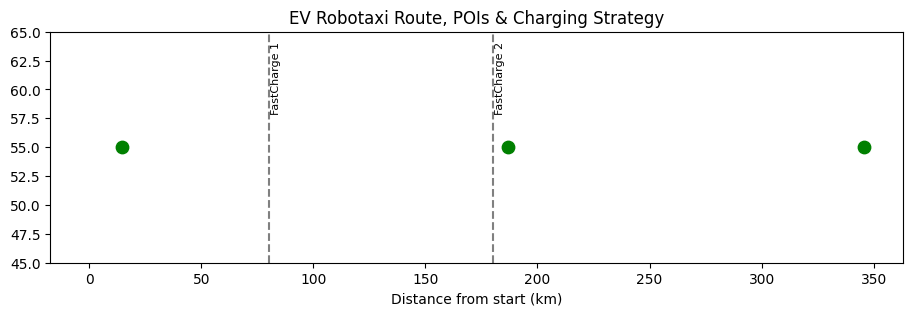

In [49]:
plt.figure(figsize=(11,3))

# Route
plt.plot(cum_km, [50]*len(cum_km), alpha=0)

# POIs
for idx in path:
    plt.scatter(cum_km[idx], 55, color="green", s=80)

# Chargers
for km, _, name in chargers:
    plt.axvline(km, linestyle="--", color="gray")
    plt.text(km+1, 58, name, rotation=90, fontsize=8)

plt.ylim(45, 65)
plt.xlabel("Distance from start (km)")
plt.title("EV Robotaxi Route, POIs & Charging Strategy")
plt.show()


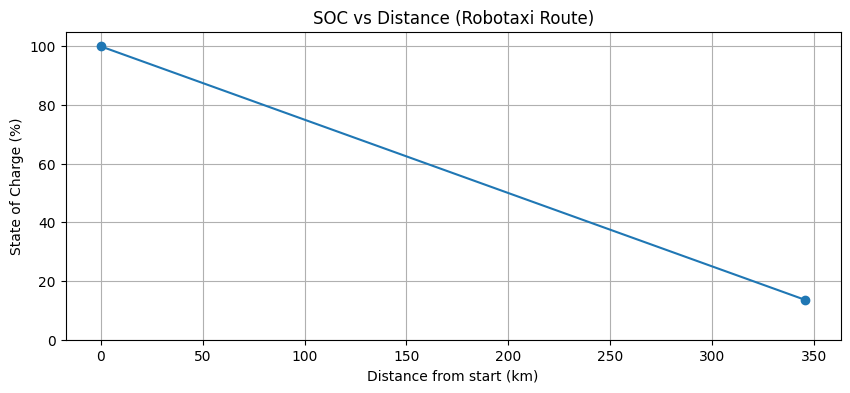

In [50]:
# ---------- SOC vs Distance (Static) ----------

def build_soc_profile(cum_km, charges,
                      battery_kwh, consumption_kwh_per_km):
    soc_km = [cum_km[0]]
    soc_pct = [100.0]

    current_energy = battery_kwh
    last_km = cum_km[0]

    # sort chargers by km
    charges_sorted = sorted(charges, key=lambda x: x["km"])

    for ch in charges_sorted:
        # energy used until charger
        dist = ch["km"] - last_km
        energy_used = dist * consumption_kwh_per_km
        current_energy -= energy_used

        soc_km.append(ch["km"])
        soc_pct.append((current_energy / battery_kwh) * 100)

        # charging event
        current_energy += ch["kwh"]
        soc_km.append(ch["km"])
        soc_pct.append((current_energy / battery_kwh) * 100)

        last_km = ch["km"]

    # final destination
    dist_end = cum_km[-1] - last_km
    current_energy -= dist_end * consumption_kwh_per_km
    soc_km.append(cum_km[-1])
    soc_pct.append((current_energy / battery_kwh) * 100)

    return soc_km, soc_pct


soc_km, soc_pct = build_soc_profile(
    cum_km,
    charges,
    BATTERY_KWH,
    CONSUMPTION_KWH_PER_KM
)

plt.figure(figsize=(10,4))
plt.plot(soc_km, soc_pct, marker="o")
plt.xlabel("Distance from start (km)")
plt.ylabel("State of Charge (%)")
plt.title("SOC vs Distance (Robotaxi Route)")
plt.grid(True)
plt.ylim(0, 105)
plt.show()


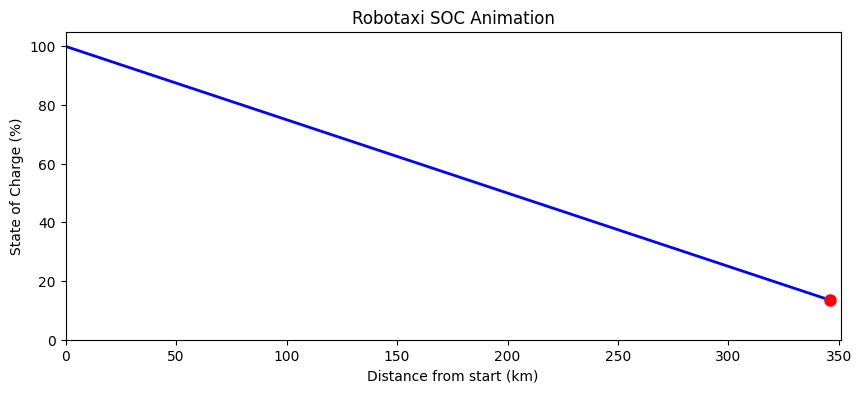

In [51]:
# ---------- SOC vs Distance Animation (FINAL, clean) ----------

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.close("all")  # ✅ prevents the extra static plot

fig, ax = plt.subplots(figsize=(10,4))

ax.set_xlim(0, cum_km[-1] + 5)
ax.set_ylim(0, 105)
ax.set_xlabel("Distance from start (km)")
ax.set_ylabel("State of Charge (%)")
ax.set_title("Robotaxi SOC Animation")

line, = ax.plot([], [], lw=2, color="blue")
point, = ax.plot([], [], "ro", markersize=8)

# Charger markers
for ch in charges:
    ax.axvline(ch["km"], linestyle="--", color="gray", alpha=0.6)
    ax.text(ch["km"] + 1, 90, ch["charger"], rotation=90, fontsize=8)

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(frame):
    x = soc_km[:frame+1]
    y = soc_pct[:frame+1]

    line.set_data(x, y)
    point.set_data([x[-1]], [y[-1]])
    return line, point

ani = FuncAnimation(
    fig,
    update,
    frames=len(soc_km),
    init_func=init,
    interval=600,
    blit=True
)

HTML(ani.to_jshtml())


In [52]:
# ---------- Road length for scenic animation ----------
ROAD_LENGTH_KM = cum_km[-1]
# ---------- Scenic environment definition ----------

environment = {
    "trees": [20, 60, 140, 220, 300],   # km positions
    "mountains": [90, 200],             # km positions
    "chargers": charges                 # reuse optimized charging plan
}
# ---------- Autonomous Robotaxi Agent (ADD THIS CELL) ----------

class Robotaxi:
    def __init__(self, battery_kwh):
        self.position_km = 0.0
        self.soc = 100.0
        self.battery_kwh = battery_kwh
        self.state = "DRIVING"  # DRIVING | CHARGING

    def update_soc(self, distance_km):
        energy_used = distance_km * CONSUMPTION_KWH_PER_KM
        self.soc -= (energy_used / self.battery_kwh) * 100



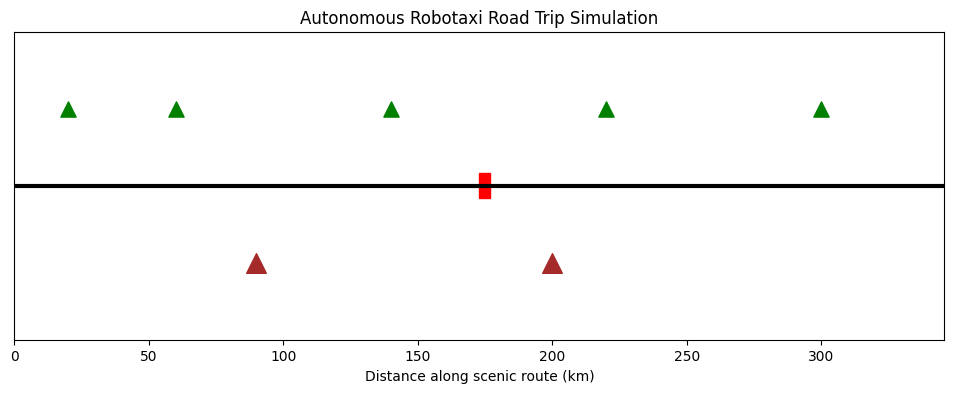

In [34]:
# ---------- Scenic Autonomous Driving Animation ----------

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plt.close("all")

fig, ax = plt.subplots(figsize=(12,4))
ax.set_xlim(0, ROAD_LENGTH_KM)
ax.set_ylim(-5, 5)
ax.set_yticks([])
ax.set_xlabel("Distance along scenic route (km)")
ax.set_title("Autonomous Robotaxi Road Trip Simulation")

# Road
ax.plot([0, ROAD_LENGTH_KM], [0, 0], color="black", linewidth=3)

# Trees 🌳
for t in environment["trees"]:
    ax.scatter(t, 2.5, marker="^", color="green", s=120)

# Mountains ⛰
for m in environment["mountains"]:
    ax.scatter(m, -2.5, marker="^", color="brown", s=200)

# Chargers ⚡
for ch in charges:
    ax.scatter(ch["km"], 0, marker="s", color="orange", s=100)
    ax.text(ch["km"], -1.2, "⚡", fontsize=14, ha="center")

# Robotaxi (car)
car = patches.Rectangle((0, -0.4), 4, 0.8, color="red")
ax.add_patch(car)

robotaxi = Robotaxi(BATTERY_KWH)

def update(frame):
    step_km = ROAD_LENGTH_KM / len(soc_km)
    robotaxi.position_km = min(frame * step_km, ROAD_LENGTH_KM)

    car.set_x(robotaxi.position_km)
    return car,

ani_drive = FuncAnimation(
    fig,
    update,
    frames=len(soc_km),
    interval=300,
    blit=True
)

HTML(ani_drive.to_jshtml())
